<h2>Molecular Dynamics in the Microcanonical Ensemble using Verlet Integration</h2>

In the Microcanonical Ensemble, the total mechanical energy of the system under consideration is kept constant, along with the number of particles and the volume of the space. 

To calculate ensemble averages for the system, we must enumerate variables over a number of possible microstates of the system. This can be achieved using a molecular dynamics simulation, where an initial state evolves over time. In the microcanonical ensemble, we aim to conserve energy, so we integrate Newton's laws, which produces many different states, each with the same conserved energy.

<h3>System:</h3>
The first system we look at is a single particle in a quadratic potential well of:
$$
U(x) = \frac{1}{2}kx^2
$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt

<h3>Energy Calculations</h3>
To ensure our simulation is physically correct, we keep track of the kinetic, potential and total energy of the system.

In [4]:
def kinetic(v, m):
    return 0.5 * m * v * v

def potential(x, k):
    return 0.5 * k * x * x

def force(x, k):
    return -k * x

<h2>Verlet Integration</h2>
To numerically integrate newton's laws with a reasonable degree of accuracy, over timestep $\delta t$, we use verlet integration - where we follow the steps as follows:

$$
v(t+\frac{1}{2}\delta t) = v(t) + \frac{1}{2}a(t) \cdot \delta t
$$
$$
x(t+\delta t) = x(t) + v(t+\frac{1}{2}\delta t) \cdot \delta t
$$
$$
a(t+\delta t) \text{ is calculated.}
$$
$$
v(t+\frac{1}{2}\delta t) = v(t) + \frac{1}{2}a(t+\delta t) \cdot \delta t
$$

Iterating this process for a small enough timestep will evolve the system according to Newton's laws of motion - with constant energy.

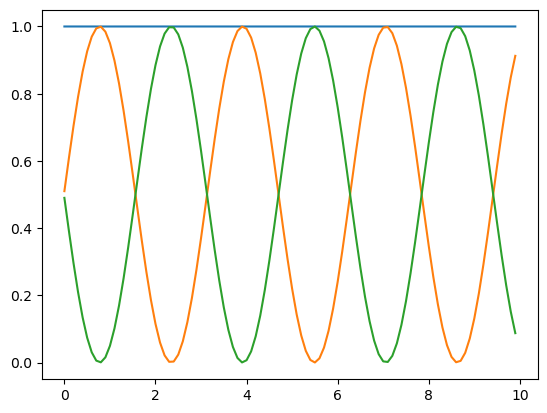

In [6]:
x = 1
v = -1

k = 1
m = 1

timestep = 0.01

a = force(x, k)

n = 1000
stepsize = 10

timePoints = np.zeros([n//stepsize])
Tenergy = np.zeros([n//stepsize])
Kenergy = np.zeros([n//stepsize])
Penergy = np.zeros([n//stepsize])
for i in range(n):
    v = v + 0.5 * a * timestep

    x = x + v * timestep

    a = force(k, x)

    v = v + 0.5 * a * timestep

    if (i%stepsize == 0):
        timePoints[i//stepsize] = i * timestep
        Tenergy[i//stepsize] = kinetic(v,m) + potential(x, k)
        Kenergy[i//stepsize] = kinetic(v,m)
        Penergy[i//stepsize] = potential(x, k)
        

plt.plot(timePoints, Tenergy)
plt.plot(timePoints, Kenergy)
plt.plot(timePoints, Penergy)


<h2>Changing the potential</h2>
We consider a second single-particle system of a particle in orbit around the origin with a position given by radius $r$ and angle $\phi$, with a potential of $U=-\frac{\alpha}{r}$.

To reduce this to a one-dimensional system with variable $r$ we must consider the angular momentum of the system. This gives us an effective potential of:
$$
U_{eff} = -\frac{\alpha}{r} + \frac{M^2}{2mr^2}
$$

where $M$ is the constant angular momentum of the system.

Implementing molecular dynamics is similar to in the last step, however we must ensure that the energy of the system is negative, which means the particle will not escape to infinity, allowing us to calculate averages while the particle oscillates about equilibrium. We can achieve this by setting the initial displacement and velocity of the particle such that the potential and kinetic energies sum to a negative value.

We set the mass $m$ and angular momentum $M$ to $1$. Using a $\alpha = 2$ we have the potential given below. To ensure our particle oscillates around equilibrium, we must initialise the system in a state with a negative energy, ensuring the motion is finite. We can easily achieve this by starting the particle at rest - where the energy is given by the negative potential term.

(-2.1, 2.0)

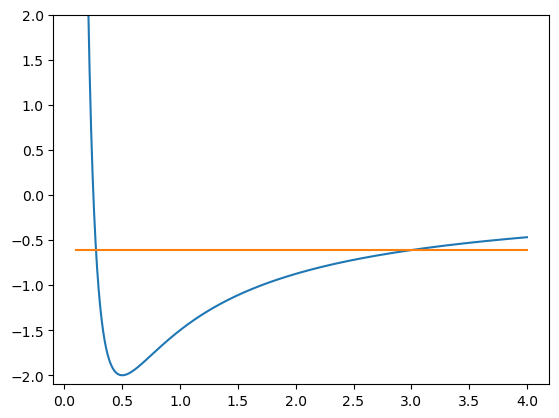

In [8]:
def kinetic(v, m):
    return 0.5 * m * v * v

def Ueff(r, alpha, M, m):
    #return 0.5 * alpha * r * r
    return M*M / (2*m*r*r) - alpha / r

def ForceEff(r, alpha, M, m):
    return - alpha * r
    return M*M / (m * r**3) - alpha / r*r

m = 1
M = 1
alpha = 2 
displacements = np.linspace(0.1, 4, 300)
potentials = np.zeros(np.shape(displacements))

constEnergy = np.ones(np.shape(displacements)) * Ueff(3, alpha, M, m)


for i in range(len(displacements)):
    potentials[i] = Ueff(displacements[i], alpha, M, m)

plt.plot(displacements, potentials)
plt.plot(displacements, constEnergy)

plt.ylim(-2.1, 2)

<h3>Verlet Integration</h3>

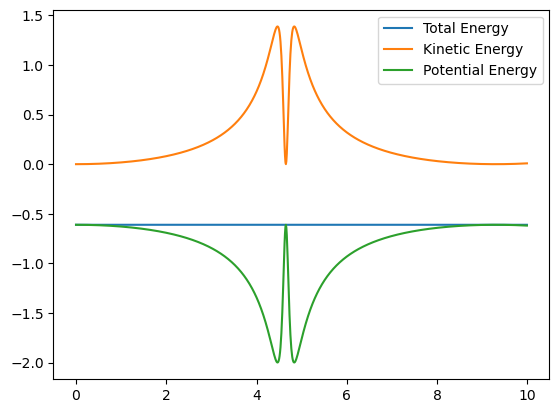

In [10]:
def kinetic(v):
    return 0.5 * v * v

def Ueff(r):
    #return r * r
    return (1 / (2*r*r)) - (2 / r)

def ForceEff(r):
    #return - 2 * r
    return (1 / (r**3)) - 2 / (r*r)

r = 3
v = 0

m = 1
M = 1
alpha = 2

timestep = 0.001

a = ForceEff(r)

n = 10000
stepsize = 10

timePoints = np.zeros([n//stepsize])
Tenergy = np.zeros([n//stepsize])
Kenergy = np.zeros([n//stepsize])
Penergy = np.zeros([n//stepsize])
pos = np.zeros([n//stepsize])
vel = np.zeros([n//stepsize])
acc = np.zeros([n//stepsize])
for i in range(n):
    v = v + 0.5 * a * timestep
    r = r + v * timestep
    a = ForceEff(r)
    v = v + 0.5 * a * timestep

    if (i%stepsize == 0):
        timePoints[i//stepsize] = i * timestep
        Kenergy[i//stepsize] = kinetic(v)
        Penergy[i//stepsize] = Ueff(r)
        Tenergy[i//stepsize] = kinetic(v) + Ueff(r)
        pos[i//stepsize] = r
        vel[i//stepsize] = v
        acc[i//stepsize] = a


plt.plot(timePoints, Tenergy, label="Total Energy")
plt.plot(timePoints, Kenergy, label="Kinetic Energy")
plt.plot(timePoints, Penergy, label="Potential Energy")

#plt.plot(timePoints, pos, label="Position")
#plt.plot(timePoints, vel, label="Velocity")
#plt.plot(pos, acc, label="Acceleration")

plt.legend()

<h3>Verlet Integration with a Langevin Thermostat</h3>
The Langevin Thermostat ensures the temperature remains constant throughout the system, by adding and removing kinetic energy.

This conserves temperature, but not energy - meaning it allows us to use molecular dynamics in the canonical ensemble.

The principles of molecular dynamics do not work when the motion of the particle is infinite, as the system does not reach equilibrium. For this project, we use a different potential - a potential well

<h4>Potential Well</h4>
To ensure our potential is continuous and differentiable, we will not use a discreet definition of an infinite well. Instead, we use the function $U(x) = x^{8}$, which provides barriers steep enough for our purpose.

Text(0, 0.5, 'Potential Energy / arbitrary units')

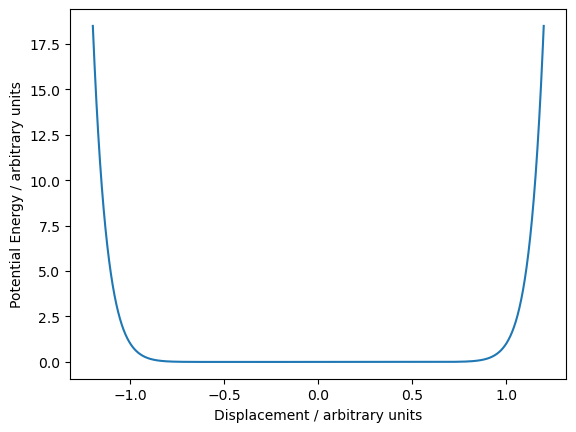

In [13]:
def potential(x):
    return x**16

def force(x):
    return -16* x**15

xvals = np.linspace(-1.2, 1.2, 1000)
yvals = np.zeros(np.size(xvals))
for i in range(len(xvals)):
    yvals[i] = potential(xvals[i])

plt.plot(xvals, yvals)
plt.xlabel("Displacement / arbitrary units")
plt.ylabel("Potential Energy / arbitrary units")

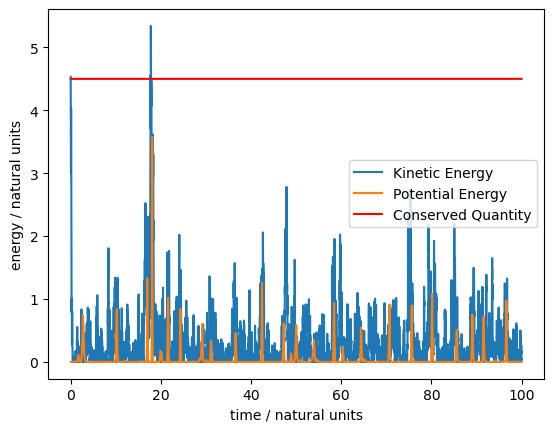

In [14]:
x = 0
v = 3
timestep = 0.001

temperature = 0.5
friction = 2

thermTerm1 = np.exp(-friction * timestep / 2)
thermTerm2 = np.sqrt(temperature * (1 - thermTerm1**2))
therm = 0 # keeps track of added / removed energy

a = force(x)

n = 100000
stepsize = 10

timePoints = np.zeros([n//stepsize])

Tenergy = np.zeros([n//stepsize])
Kenergy = np.zeros([n//stepsize])
Penergy = np.zeros([n//stepsize])

pos = np.zeros([n//stepsize])
vel = np.zeros([n//stepsize])
acc = np.zeros([n//stepsize])
for i in range(n):
    #Thermostat step 1
    therm += kinetic(v)
    v = v * thermTerm1 + thermTerm2 * np.random.normal()
    therm -= kinetic(v)

    #Verlet integration
    v = v + 0.5 * a * timestep
    
    x = x + v * timestep
    
    a = force(x)
    
    v = v + 0.5 * a * timestep

    #Thermostat step 2
    therm += kinetic(v)
    v = v * thermTerm1 + thermTerm2 * np.random.normal()
    therm -= kinetic(v)

    if (i%stepsize == 0):
        timePoints[i//stepsize] = i * timestep
        Kenergy[i//stepsize] = kinetic(v)
        Penergy[i//stepsize] = potential(x)
        Tenergy[i//stepsize] = kinetic(v) + potential(x) + therm
        pos[i//stepsize] = x
        vel[i//stepsize] = v
        acc[i//stepsize] = a


plt.plot(timePoints, Kenergy, label="Kinetic Energy")
plt.plot(timePoints, Penergy, label="Potential Energy")
plt.plot(timePoints, Tenergy, 'r-', label="Conserved Quantity")

#plt.plot(timePoints, pos, label="Position")
#plt.plot(timePoints, vel, label="Velocity")
#plt.plot(pos, acc, label="Acceleration")

plt.xlabel("time / natural units")
plt.ylabel("energy / natural units")

plt.legend()

Text(0, 0.5, 'displacement / natural units')

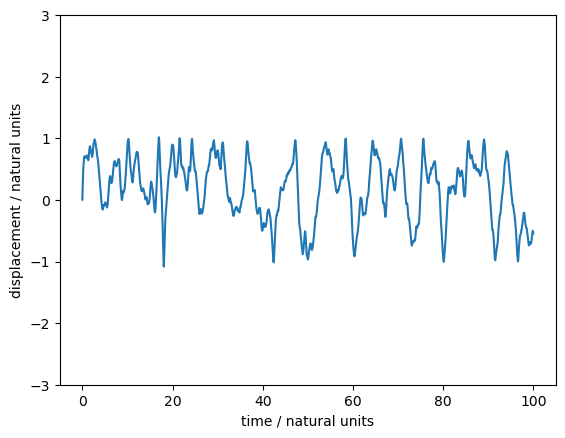

In [15]:
plt.plot(timePoints, pos)
plt.ylim([-3, 3])

plt.xlabel("time / natural units")
plt.ylabel("displacement / natural units")

<h2>Average energy with MD simulations</h2>
We use MD simulations to average energy for given temperatures. The error of such averages is calculated using block averaging.

In [17]:
#Calculates the average energy and error for a temperature
#returns (average, error)
def averageEnergy(temperature, blockSize):
    #Initial particle variables
    x = 0
    v = 3
    a = force(x)

    #Thermostat initialisation
    timestep = 0.0005
    friction = 2
    thermTerm1 = np.exp(-friction * timestep / 2)
    thermTerm2 = np.sqrt(temperature * (1 - thermTerm1**2))    

    #Stores energies
    n = 500000
    stepsize = 10
    energies = np.zeros([n//stepsize])

    #Simulates movement and energies
    for i in range(n):
        
        #Thermostat step 1
        v = v * thermTerm1 + thermTerm2 * np.random.normal()    
        
        #Verlet integration
        v = v + 0.5 * a * timestep        
        x = x + v * timestep        
        a = force(x)        
        v = v + 0.5 * a * timestep
        
        #Thermostat step 2
        v = v * thermTerm1 + thermTerm2 * np.random.normal()
    
        if (i%stepsize == 0):
            energies[i//stepsize] = kinetic(v) + potential(x)

    
    #Block averages the energies
    blocks = np.zeros(len(energies)//blockSize)

    blockAvgEnergy = 0
    blockAvgSquareEnergy = 0
    for i in range(len(blocks)): # Each Block
        averageE = 0
        for j in range(blockSize): # Data within each block
            averageE += energies[i * blockSize + j]
        averageE /= blockSize

        blockAvgEnergy += averageE
        blockAvgSquareEnergy += averageE * averageE
    blockAvgEnergy /= len(blocks)
    blockAvgSquareEnergy /= len(blocks)

    variance = 1/(len(blocks)-1) * (blockAvgSquareEnergy - blockAvgEnergy ** 2)
    error = np.sqrt(variance)

    return (blockAvgEnergy, error)

<h3>Choosing the optimal block size</h3>

These computations use a temperature of 1.

Using the graph, we can see that we need to use a block size of at least 200 to avoid underestimating the error.

[0.26933494 0.26933494 0.26933494 0.26933494 0.26933494 0.26933494
 0.26933494]
[0.00479322 0.00725829 0.00950954 0.01178338 0.0133563  0.01437738
 0.01445589]


Text(0, 0.5, 'Average Energy / natural units')

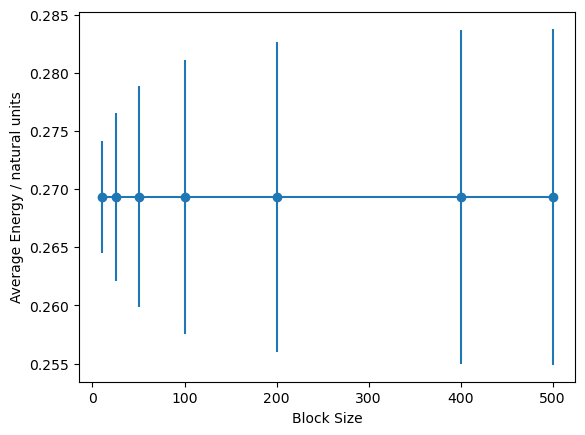

In [19]:
blockSizes = [10, 25, 50, 100, 200, 400, 500]

energies = np.zeros(len(blockSizes))
errors = np.zeros(len(blockSizes))

for i in range(len(blockSizes)):
    np.random.seed(0)
    energy, error = averageEnergy(0.5, blockSizes[i])
    energies[i] = energy
    errors[i] = error

print(energies)
print(errors)
plt.scatter(blockSizes, energies)
plt.errorbar(blockSizes, energies, yerr = errors)

plt.xlabel("Block Size")
plt.ylabel("Average Energy / natural units")

<h2>Final Result - Average Energy and Temperature</h2>

Text(0, 0.5, 'Average Energy / natural units')

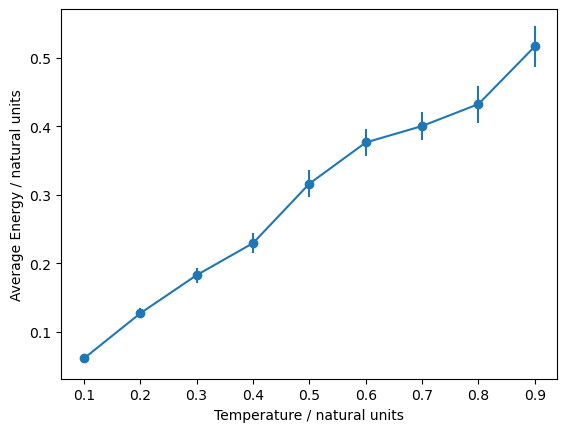

In [21]:
temperatures = np.arange(0.1, 1.0, 0.1)
energies = np.zeros(len(temperatures))
errors = np.zeros(len(temperatures))
for i in range(len(temperatures)):
    energy, error = averageEnergy(temperatures[i], 200)
    energies[i] = energy
    errors[i] = error

plt.scatter(temperatures, energies)
plt.errorbar(temperatures, energies, yerr = errors)

plt.xlabel("Temperature / natural units")
plt.ylabel("Average Energy / natural units")